# Store Sales Time Series Forecasting
<p>The main mission with this notebook is around predicting sales for each product family and store combination. The 6 pieces of data that will be used are: (a) train, (b) test, (c) store, (d) transactions, (e) holidays and events, and (f) daily oil prices.</p>

In [1]:
import warnings
warnings.filterwarnings("ignore")

## 1. Importing Packages
<p>Including the packages below.</p>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. Importing Data
<p>Converting the files within the 'datasets' folder into DataFrames. Also making a few data type modifications.</p>

In [3]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
stores = pd.read_csv('datasets/stores.csv')
sub = pd.read_csv('datasets/sample_submission.csv')
transactions = pd.read_csv('datasets/transactions.csv')
oil = pd.read_csv('datasets/oil.csv')

In [4]:
train["date"] = pd.to_datetime(train["date"])
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [5]:
test["date"] = pd.to_datetime(test["date"])
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [6]:
stores.cluster = stores.cluster.astype("int8")
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
transactions = transactions.sort_values(["store_nbr", "date"])
transactions["date"] = pd.to_datetime(transactions["date"])
transactions.head()

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520


## 3. Transactions
<p>Starting off with transaction data... This dataset conveys how many people came to the store and how many invoices were created in a day.</p>
<p>The training data provides information around the total sales of each product family at a particular store on a given date. Fractional values are possible since products can be sold in fractional units.</p>
<p>By grouping 'date' and 'store_nbr', the transactions dataset serves as a valuable feature store during the model creation process. New features will be generated by using the transactions dataset.</p>

In [8]:
groupdf = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
stdf = pd.merge(groupdf, transactions, how="left")

# Printing out a merged dataframe. One consolidated view of sales and transactions.
stdf.tail()

,date,store_nbr,sales,transactions
90931,2017-08-15,50,16879.121094,2804.0
90932,2017-08-15,51,20154.558594,1573.0
90933,2017-08-15,52,18600.046875,2255.0
90934,2017-08-15,53,8208.189453,932.0
90935,2017-08-15,54,12666.858398,802.0


In [9]:
# How well are sales and transactions correlated?
# The Spearman correlation coefficient can help answer this question.

spCorrCoeff = stdf.corr("spearman").sales.loc["transactions"]
print("Spearman Correlation Coefficient: {:,.4f}" .format(spCorrCoeff))

Spearman Correlation Coefficient: 0.8175


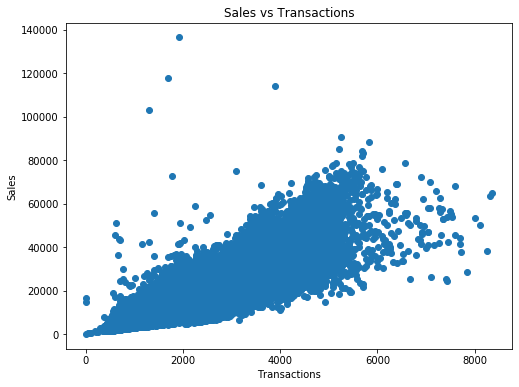

In [10]:
# Visualizing the correlation between sales and transactions.
# TODO: Add a regression line to the plot.

plt.figure(figsize=(8, 6))
plt.scatter(stdf["transactions"], stdf["sales"])
plt.title("Sales vs Transactions")
plt.xlabel("Transactions")
plt.ylabel("Sales")
plt.show()

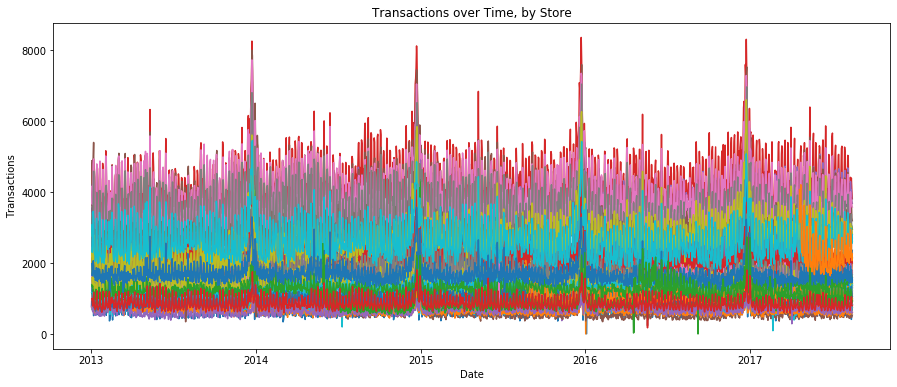

In [11]:
# Creating a neat visualization, mapping transactions over time by store.
%matplotlib inline

# Mapping the plotting variables correctly.
transactionSort = transactions.sort_values(["store_nbr", "date"])
x = transactionSort["date"]
y = transactionSort["transactions"]

# Sizing the plot.
plt.figure(figsize=(15, 6))

# Labeling and coloring appropriately.
ts_group = transactionSort.groupby("store_nbr")
for store_nbr, data in ts_group:
    plt.plot(data["date"], data["transactions"], label=f"Store {store_nbr}")

# Adding a legend and title.
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title("Transactions over Time, by Store")
#plt.legend()
plt.show()

Text(0.5, 1.0, 'Transactions over Time, by Year')

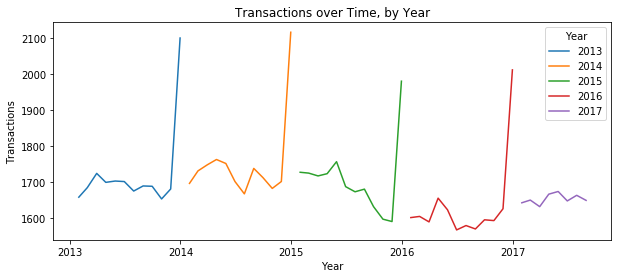

In [12]:
a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year

# Sizing the plot.
plt.figure(figsize=(10, 4))

# Labeling and coloring appropriately.
for year, data in a.groupby("year"):
    plt.plot(data["date"], data["transactions"], label=year)

# Adding a legend and title.
plt.xlabel("Year")
plt.ylabel("Transactions")
plt.legend(title="Year")
plt.title("Transactions over Time, by Year")

<p>A key takeaway from the line graphs above: the store sales increase at the end of each year.</p>

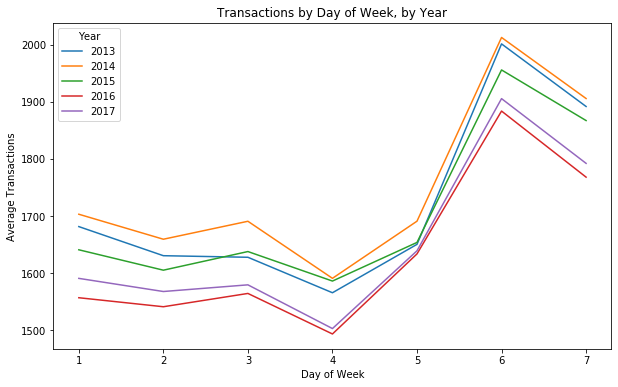

In [13]:
x = transactions.copy()

# Extracting the year and day of the week from the 'date' column the DataFrame.
# Create new columns 'year' and 'dayofweek'.
x["year"] = x.date.dt.year
x["dayofweek"] = x.date.dt.dayofweek + 1

# Group the DataFrame by 'year' and 'dayofweek', calculating the mean of transactions for each group.
# The result is a new DataFrame with columns 'year', 'dayofweek', and 'transactions'.
x = x.groupby(["year", "dayofweek"]).transactions.mean().reset_index()

# Pivot the DataFrame to have 'dayofweek' as the index, 'year' as the columns, and 'transactions' as values.
# This creates a DataFrame suitable for plotting with each column representing a different year.
x_pivot = x.pivot(index="dayofweek", columns="year", values="transactions")

plt.figure(figsize=(10, 6))

# Iterate over the unique years in the DataFrame.
# For each year, plot a line using the 'dayofweek' as the x-axis.
# For the y-axis, map the corresponding values from the 'transactions' column for that year.
# The label parameter is set to the string representation of the year, creating the legend.
for year in x["year"].unique():
    plt.plot(x_pivot.index, x_pivot[year], label=year)

plt.title("Transactions by Day of Week, by Year")
plt.xlabel("Day of Week")
plt.ylabel("Average Transactions")
plt.legend(title="Year")
plt.show()

<p>Key takeaway: stores make more transactions over the weekends. Saturday (day 6) sees the highest demand.</p>

## 4. Oil Prices

<p>There are a few missing data points in the oil data below. A simple, suitable solution for this is linear interpolation. Since this is time-series data, the trend can be discerned and missing values can be filled in.</p>

In [14]:
# 43 data points exist in the 'dcoilwtico' column with a missing value.
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

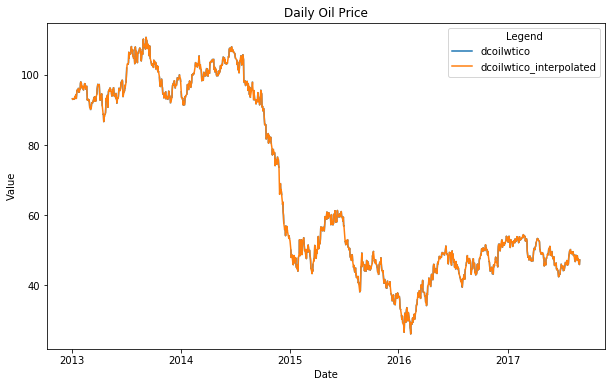

In [15]:
# Converting the 'date' column into the datetime format.
oil["date"] = pd.to_datetime(oil.date)

# Set the 'date' column as the index, resample to daily frequency, sum values for each day.
# And then reset the index.
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()

# Replacing the 0 values in the 'dcoilwtico' column with NaN.
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])

# Time for some interpolation...
oil["dcoilwtico_interpolated"] = oil.dcoilwtico.interpolate()

# Melting the DataFrame into a long format.
# Columns 'date', 'Legend' (interpolated/non-interpolated), and 'value'.
pl = oil.melt(id_vars = ["date"] + list(oil.keys()[5:]), var_name = "Legend")

# Sorting the DataFrame by 'Legend' and 'date'.
pl_sorted = pl.sort_values(["Legend", "date"], ascending=[False, True])

plt.figure(figsize=(10, 6))

# Plotting the 'date' column on the x-axis and the 'value' column on the y-axis.
for legend, group in pl_sorted.groupby("Legend"):
    plt.plot(group["date"], group["value"], label=legend)

plt.title("Daily Oil Price")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(title="Legend")
plt.show()

<p>With the interpolation now complete, the next task is to assess whether there is any correlation between Ecuador's oil prices and the sales/transcations occuring in the country. Economies are complex entities, but, for the sake of this project, we will simplify. The oil prices will be treated as a proxy for measuring the country's economic health.</p>

In [16]:
# Merge the 'stdf' DataFrame with the 'oil' DataFrame on the common key ('date') using a left join
stdf = pd.merge(stdf, oil, how="left")

print("Correlation with Daily Oil Prices")

# Calculate the Spearman correlation between 'dcoilwtico_interpolated' and 'sales', 'transactions'
# Drop irrelevant columns ('store_nbr', 'dcoilwtico') before calculating the correlation
correlation_result = stdf.drop(["store_nbr", "dcoilwtico"], axis=1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]]

# Print the correlation results
print(correlation_result, "\n")

Correlation with Daily Oil Prices
sales          -0.303237
transactions    0.040105
Name: dcoilwtico_interpolated, dtype: float64 



<p>Correlation are causation are not the same thing. The only takeaway we can make from the above calculation is that sales and oil prices are negatively correlated, if only by -0.30. These analyses are designed to ask better questions, not rush to conclusions.</p>